# Bayesian Hierarchical Time Series

Author: Leo Guelman


Building a "toy" version of [Prophet](https://peerj.com/preprints/3190/) from scratch to accommodate for time series that follow a hierarchical structure.

### Table of Contents

* [1. Imports](#imports1)
* [2. Data](#data2)
* [3. Forecasting Model](#model3)
    * [3.1 Linear Trend Component](#trend3_1)
    * [3.2 Seasonality Component](#seasonality3_2)
    * [3.3 Combining Trend and Seasonality](#trend_seasonality3_3)
* [4. Fitting all Series Independenty](#independent_fits_4)
* [5. Comparisson with FB Prophet](#prophet_5)
* [6. Hierarchical Approach](#hierarchical_6)
 * [6.1 The Model](#themodel_61)
 * [6.2 Stan Code and Fitting Procedure](#stanfit_62)
 * [6.3 MCMC Diagnostics](#diagnostics_63)
 * [6.4 Forecasts](#forecasts_64)
* [7. Prediction Error](#pred_error7)

 
 
 
 
 
 
 

## 1. Imports <a class="anchor" id="imports1"></a>

In [1]:
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
parameters = {'figure.figsize': (8, 4),
              'font.size': 8, 
              'axes.labelsize': 12}
plt.rcParams.update(parameters)
plt.style.use('fivethirtyeight')

import pystan
import multiprocessing
import stan_utility
import arviz as az


from python.ts_utils import get_linear_trend_data, fourier_series, \
                            plot_posterior, plot_prophet, stan_model_summary, forecast, \
                            forecast_hierarchical

## 2. Data <a class="anchor" id="data2"></a>

For the sake of illustration, in this notebook we will focus on quarterly domestic tourism demand in the New South Wales (NSW) region in Australia. This region is further subdivided into five smaller areas of interest, referred to as zones: Metro (NSWMetro), North Coast (NSWNthCo), South Coast (NSWSthCo), South Inner (NSWSthIn), North Inner (NSWNthIn). Domestic tourism demand is measured as the number of visitor nights Australians spend away from home. The data is in the [fpp2](https://cran.r-project.org/web/packages/fpp2/index.html) R package, with slight modified as specified below.

In [2]:
### Get data and add stronger trend for illustration 
visnights = pd.read_csv('../data/visnights_data.csv')
visnights = visnights.assign(
    date = lambda df: pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    )
n_obs = visnights.shape[0]
adj = np.logspace(0, 0.2, num=n_obs)
visnights['NSWMetro'] = visnights['NSWMetro'].values * adj
visnights['NSWNthCo'] = visnights['NSWNthCo'].values * adj
visnights['NSWSthCo'] = visnights['NSWSthCo'].values * adj
visnights['NSWSthIn'] = visnights['NSWSthIn'].values * adj
visnights['NSWNthIn'] = visnights['NSWNthIn'].values * adj
visnights = visnights.drop(['year', 'month'], axis=1)
visnights = visnights.set_index('date')
print("Number of observations:", n_obs, "\n")
visnights.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Number of observations: 76 



,NSWMetro,NSWNthCo,NSWSthCo,NSWSthIn,NSWNthIn
date,,,,,
1998-01-01,9.047095,8.565678,5.818029,2.679538,2.977507
1998-04-01,7.005006,7.168349,2.481628,3.029276,3.499122
1998-07-01,6.956874,4.775176,1.951876,3.370001,3.052021
1998-10-01,7.280171,6.385854,2.849566,2.462722,3.827838
1999-01-01,8.154772,9.729967,4.974368,3.304457,3.885017


The figure below shows that all series share common features of trend and seasonality. As expected, tourism demand exhibits yearly seasonality, and this is reflected in spikes in each series during the first quarter of the year. Also, the series shows an upward trend that is more pronounced in the last few years.

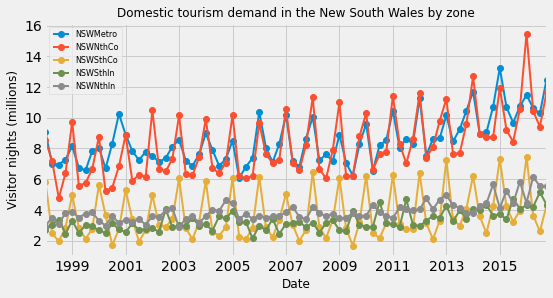

In [3]:
# Plot time series

ax = visnights.plot(linewidth=2, marker='o');
ax.set_xlabel('Date', fontsize=12);
ax.set_ylabel('Visitor nights (millions)', fontsize=12);
ax.set_title("Domestic tourism demand in the New South Wales by zone", fontsize=12)
ax.legend(fontsize=8);

## 3. Forecasting Model  <a class="anchor" id="model3"></a>

We focus here on the need to produce a large number of fortecast in an automated fashion, where the individual time series to be forecasted share some common features of trend and/or seasonality. 

Methods that explicitly account for the temporal dependence structure in the data, such as Automatic ARIMA or Exponential Smoothing, require a significant amount of tuning. Unless tuned properly, they produce forecast that struggle to match the characteristics of the series. We instead follow the model proposed in [Prophet](https://peerj.com/preprints/3190/), which frames the forecasting problem as a curve-fitting exercise. Specifically, we decompose a time series $y(t)$ into three main components of trend, seasonality, and holidays:

$$
y(t)= g(t) + s(t) + h(t) + e_t.
$$

Here $g(t)$ is the trend function which models non-periodic changes in the value of the time series, $s(t)$ represents periodic changes, and $h(t)$ represents the effects of holidays which occur on potentially irregular schedules over
one or more days. The error term $e_t$ represents any idiosyncratic changes that are not
accounted by the aforementioned components.

We cover the trend and seasonality components below. Holidays follow a similar model structure as seasonal effects, and so we leave them out from this example. 

### 3.1 Linear Trend Component  <a class="anchor" id="trend3_1"></a>

We fit the following trend model to the data:

\begin{align*} 
y &\sim N(\mu_{\text{trend}},\sigma) \\ 
\mu_{\text{trend}} &= (k + \mathbf{A} \mathbf{\delta})t + (m+\mathbf{A} \gamma)  \\
\gamma &= -s * \delta \\
k &\sim N(0,5) \\
m &\sim N(0,5) \\
\delta &\sim \text{Laplace}(0,1) \\
\sigma &\sim \text{Half-normal}(0,.5),\\
\end{align*}

where trend changes are incoporated explicitly by defining a set of $s_j$,$~j=\{1, \ldots, n\}$ changepoints in which the trend is supposed to change, $k$ is the base growth rate, $\mathbf{\delta} \in \mathbb{R}^n$ is a vector of rate adjustments, $m$ is an offset parameter, and $\gamma$ is set equal to $-s * \delta$ so the trend function continuous.

The rate at any time $t$ is then the base rate $k$, plus all the rate adjustments up to that point: $k + \sum_{j:t>s_j}\delta_j$. This is represented in the model by incorporating a changepoint matrix $A$ in the declaration of the mean trend, $\mu_{\text{trend}}$:

\begin{equation*}
A=
\begin{bmatrix}
t_1 \geq s_1 & \ldots & t_1 \geq  s_n\\
\vdots & \ddots & \vdots \\
t_l \geq s_1 & \ldots & t_l \geq  s_n
\end{bmatrix}.
\end{equation*}

The trend model defined above can be expressed in [stan](https://mc-stan.org/) as follows:

In [4]:
### Stored in "stan_trend.stan"

stan_model = """

data { 

  int N;                              // Number of time periods
  int N_changepoints;                 // Number of changepoints
  vector[N_changepoints] s;           // Changepoints
  matrix[N, N_changepoints] A;        // Changepoint Matrix
  vector[N] t;                        // Time
  vector[N] y;                        // Time series
  real<lower=0> tau;                  // Scale on changepoints prior
 
} 
 
parameters { 
    
  vector[N_changepoints] delta;      // Trend rate adjustments
  real k;                            // Base trend growth rate
  real m;                            // Trend offset
  real<lower=0> sigma_trend;         // Observation noise

} 
 
transformed parameters { 
  
  vector[N_changepoints] gamma;
  vector[N] mu_trend; 
  
  gamma = -s .* delta;
  mu_trend = k + A * delta .* t + (m + A * gamma);
   
} 
 
model { 

  // Priors
  k ~ normal(0, 5);
  m ~ normal(0, 5);
  delta ~ double_exponential(0, tau);
  sigma_trend ~ normal(0, 0.5);
  
  // Linear likelihood
  y ~ normal(mu_trend, sigma_trend);

} 

generated quantities { 
    
    vector[N] y_hat;
    for (n in 1:N)
        y_hat[n] = normal_rng(mu_trend[n], sigma_trend);  
}
"""

For illustration purposes first, we fit the trend model to a single region (North Coast). We keep the stan code on a separate file named `stan_trend.stan` and execute it with [PyStan](https://github.com/stan-dev/pystan2). 

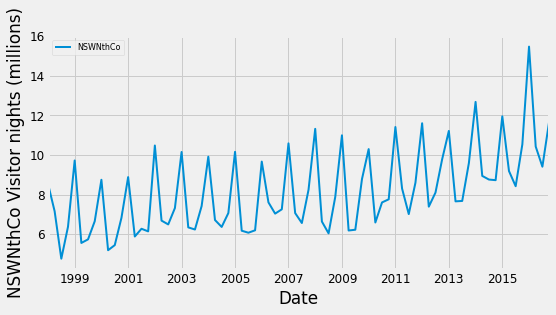

In [5]:
# Plot region
NSWNthCo_df = visnights.loc[:,'NSWNthCo']
ax = NSWNthCo_df.plot(linewidth=2, fontsize=12);
ax.set_xlabel('Date');
ax.set_ylabel('NSWNthCo Visitor nights (millions)');
ax.legend(fontsize=8);

In [6]:
# Get trend inputs
t, s, A = get_linear_trend_data(NSWNthCo_df.values, n_changepoints = 10)

# Fit linear Trend 
stan_data_dict = {'N':NSWNthCo_df.shape[0],
                  'N_changepoints':len(s),
                  's': s,
                  'A': A,
                  't': t,
                  'y': NSWNthCo_df.values,
                  'tau': 1  # changepoint.prior.scale (default = 0.05)
                  }

sm = pystan.StanModel('../stan/stan_trend.stan') 
multiprocessing.set_start_method("fork", force=True)
fit1 = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4116f5c65890ad715a3f7554a4e32f28 NOW.


Below we plot the mean and 90% credibility intervals on the posterior mean trend $\mu_{\text{trend}}$ along with the actual values of the series. The credibility interval illustrate the *epistemic uncertainty* of the model. The vertical lines show the changepoints, with the number of points being specified in the `n_changepoints` argument. This returns evenly spaced changepoints over the time interval scaled to the $[0,1]$ range.

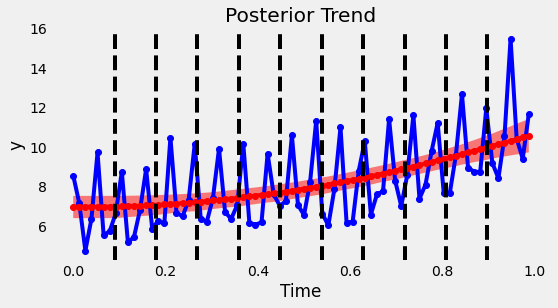

In [7]:
plot_posterior(stan_fit = fit1, component = 'trend', 
               ts = NSWNthCo_df.values, s = s, ci = [0.05, 0.95])

The second plot below corresponds to the mean posterior prediction $\hat{y}$ along with the 90% credibility interval, which in addition captures the *aleatoric uncertainty* in prediction (notice the wider interval and the fact that the linear trend wiggles within each changepoint as a result of the inclusion of aleatoric uncertainty). 

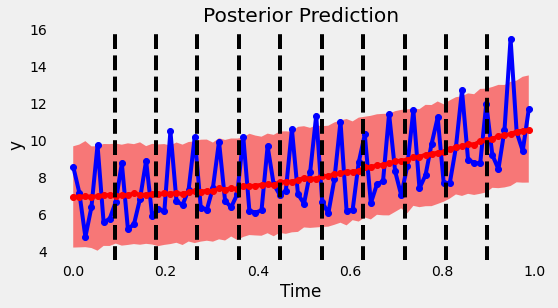

In [8]:
plot_posterior(stan_fit = fit1, component = 'prediction', 
               ts = NSWNthCo_df.values, s = s, ci = [0.05, 0.95])

### 3.2 Seasonality Component  <a class="anchor" id="seasonality3_2"></a>

Seasonal effect are captured by Fourier series, which can approximate arbitrary smooth effects by adding up periodic function of $t$:

$$
s(t) = \sum_{r=1}^{R} \Bigg(a_n \text{cos} \big(\frac{2\pi rt}{P}\Big) + b_n \text{sin} \big(\frac{2\pi rt}{P}\Big) \Bigg).
$$

The seasonality model follows a simple specification:



\begin{align*} 
y &\sim N(\mu_{\text{seasonality}},\sigma) \\ 
\mu_{\text{seasonality}} &= \mathbf{X} \mathbf{\beta} \\
\mathbf{\beta} &\sim N(0,\sigma_{\beta}) \\
\sigma &\sim \text{Half-normal}(0,.5),\\
\end{align*}

where 

$$
\mathbf{\beta} = [a_1, b_1, \ldots, a_R , b_R]^\top,
$$

and


\begin{equation*}
\mathbf{X} =
\begin{bmatrix}
\text{cos} \Big(\frac{2 \pi \times 1 \times t_1}{P}\Big) &  \text{sin} \Big(\frac{2 \pi \times 1 \times t_1}{P}\Big)  & \ldots & \text{cos} \Big(\frac{2 \pi \times R \times t_1}{P}\Big) &  \text{sin} \Big(\frac{2 \pi \times R \times t_1}{P}\Big) \\
\vdots & \vdots  & \ddots & \vdots & \vdots \\
\text{cos} \Big(\frac{2 \pi \times 1 \times t_l}{P}\Big) &  \text{sin} \Big(\frac{2 \pi \times 1 \times t_l}{P}\Big)  & \ldots & \text{cos} \Big(\frac{2 \pi \times R \times t_l}{P}\Big) &  \text{sin} \Big(\frac{2 \pi \times R \times t_l}{P}\Big)  \\
\end{bmatrix}.
\end{equation*}


We fit this model is stan using the code below. 

In [9]:
### Stored in "stan_seasonality.stan"

stan_seasonality = """

data { 

  int N;                              // Number of time periods
  int n_fourier;                      // Fourier series explansion
  matrix[N, n_fourier * 2] X;         // Seasonality matrix
  vector[N] y;                        // Time series
  real<lower=0> sigma_beta;           // Scale on seasonality prior
  
} 
 
parameters { 
    
  vector[n_fourier * 2] beta;        // Seasonality regressor coefficients
  real<lower=0> sigma_s;             // Observation noise

} 

transformed parameters { 
  
  vector[N] mu_s; 
  mu_s = X * beta;
   
} 
 
model { 

  // Priors
  beta ~ normal(0, sigma_beta);
  sigma_s ~ normal(0, 0.5);
  
  // Linear likelihood
  y ~ normal(mu_s, sigma_s);

} 

generated quantities { 
    
    vector[N] y_hat;
    for (n in 1:N)
        y_hat[n] = normal_rng(mu_s[n], sigma_s);  
}
"""

In [10]:
# Create Seasonality matrix

n_fourier = 10
X = fourier_series(t, p=4, fourier_order=n_fourier) # p=4 becuase we have yearly seasonality with quarterly data

stan_data_dict_s = {'N':NSWNthCo_df.shape[0],
                    'n_fourier':n_fourier,
                    'X':X,
                    'y': NSWNthCo_df.values,
                    'sigma_beta': 10,
                   }

sm = pystan.StanModel('../stan/stan_seasonality.stan') 
multiprocessing.set_start_method("fork", force=True)
fit2 = sm.sampling(data=stan_data_dict_s, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5494793963d5a92a2aa1cb7ab4334b1 NOW.


Finally, we plot below the posterior prediction for $\mu_{\text{seasonality}}$ along with 90% credibilty interval, and the poterior prediction $\hat{y}$, the latter including the alteatoric uncertainty captured in $\hat{\sigma}$.

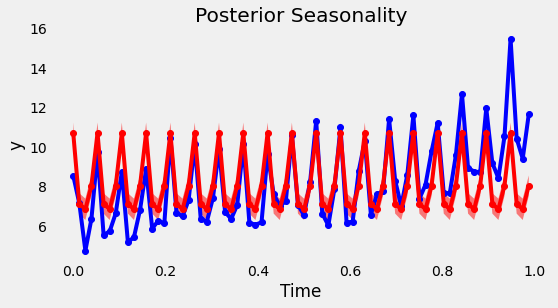

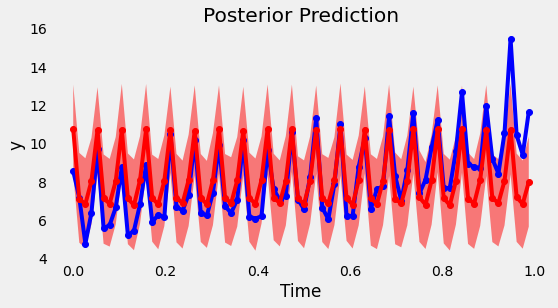

In [11]:
plot_posterior(stan_fit = fit2, component = 'seasonality', ts = NSWNthCo_df.values)

plot_posterior(stan_fit = fit2, component = 'prediction', ts = NSWNthCo_df.values)


### 3.3 Combining Trend and Seasonality  <a class="anchor" id="trend_seasonality3_3"></a>


Let's now combine the trend and seasonality components into a single fit. This is coded in the stan model `stan_model.stan`, included in the GitHub repo. 

In [12]:
stan_data_dict = {'N':NSWNthCo_df.shape[0],
                  'N_changepoints':len(s),
                  's': s,
                  'A': A,
                  't': t,
                  'n_fourier':n_fourier,
                  'X':X,
                  'y': NSWNthCo_df.values,
                  'tau': 1 ,        # changepoint.prior.scale
                  'sigma_beta': 10  # seasonality.prior.scale = 10 (default),
                  }

sm = pystan.StanModel('../stan/stan_model.stan') 
multiprocessing.set_start_method("fork", force=True)
fit3 = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


And here's the visualization of the trend, seasonality, and prediction posteriors.

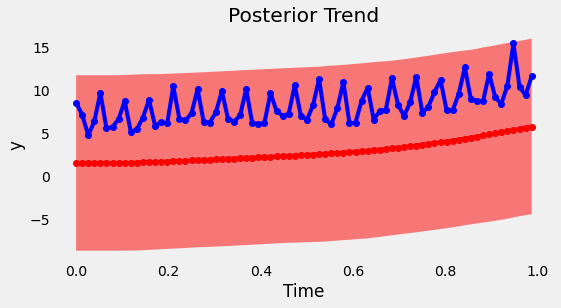

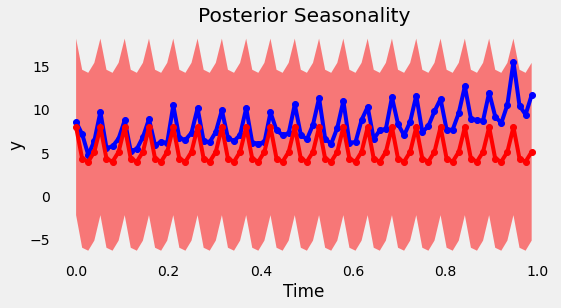

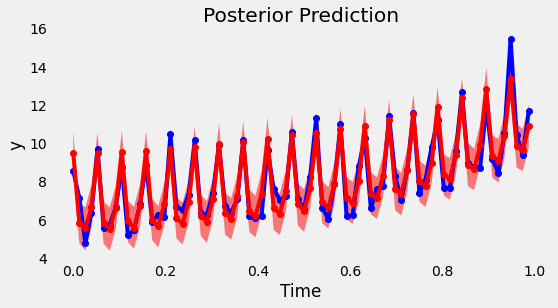

In [13]:
plot_posterior(stan_fit = fit3, component = 'trend', ts = NSWNthCo_df)

plot_posterior(stan_fit = fit3, component = 'seasonality', ts = NSWNthCo_df)

plot_posterior(stan_fit = fit3, component = 'prediction', ts = NSWNthCo_df)

## 4. Fitting all Series Independenty  <a class="anchor" id="independent_fits_4"></a>

We use the same framework described in [Section 3](#model3), to fit individual time series to each of the five areas within the New South Wales. In doing so, we first split each series into a train (first 66 quarterly observations), and test sets (last 10 quarterly observations).

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


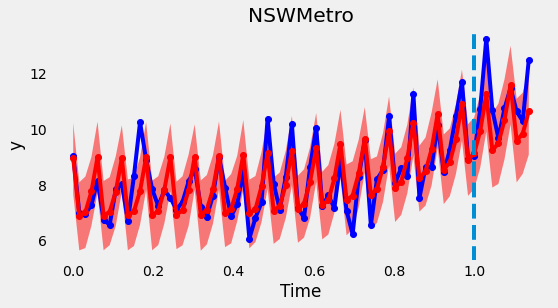

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


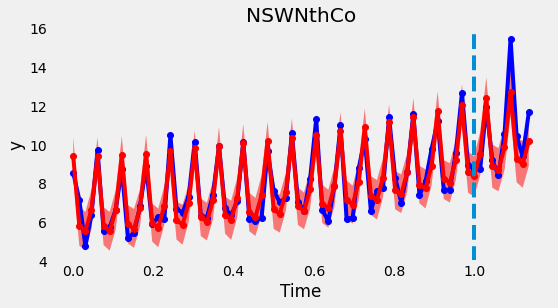

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


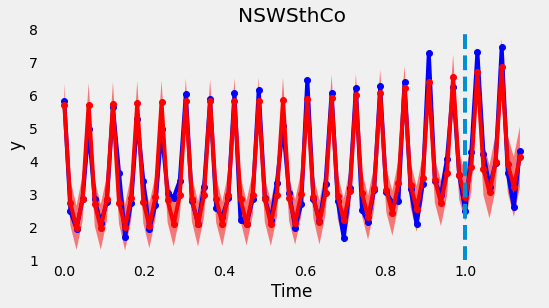

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


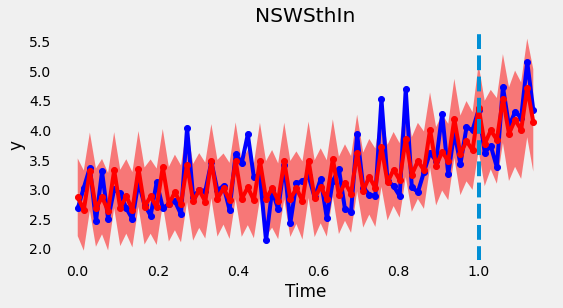

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc6ab2f2c0931256c223d2cdeb22a047 NOW.


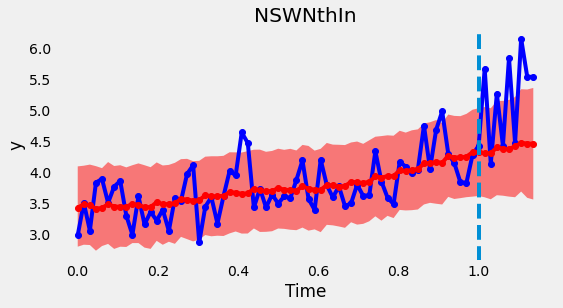

In [14]:
zones = ['NSWMetro', 'NSWNthCo', 'NSWSthCo', 'NSWSthIn', 'NSWNthIn']
n_fourier = 10
n_changepoints = 10
p = 4
tau = 1  #Changepoint.prior.scale
sigma_beta = 10 #Seasonality.prior.scale = 10 (default),
horizon = 10 #Forecast horizon 

y_hat_zones = []

for zone in zones:
    
    df = visnights.loc[:,zone]
    df_train = df.iloc[0:(df.shape[0] - horizon)]
    df_test =  df.iloc[(df.shape[0] - horizon):df.shape[0]]
    
    # Trend inputs
    t, s, A = get_linear_trend_data(df_train.values, n_changepoints = n_changepoints)

    # Seasonality inputs
    X = fourier_series(t, p=p, fourier_order=n_fourier) 

    stan_data_dict = {'N':df_train.shape[0],
                      'N_changepoints':len(s),
                      's': s,
                      'A': A,
                      't': t,
                      'n_fourier':n_fourier,
                      'X':X,
                      'y': df_train.values,
                      'tau': tau ,     
                      'sigma_beta': sigma_beta  
                      }
    
    sm = pystan.StanModel('../stan/stan_model.stan') 
    multiprocessing.set_start_method("fork", force=True)
    fit4 = sm.sampling(data=stan_data_dict, iter=1000, chains=4)
    y_hat, *_ = forecast(fit4, p = p, horizon = horizon)
    y_hat_zones.append(y_hat)
    plot_posterior(fit4, ts = df.values, 
                   yhat = y_hat, horizon = horizon, title = zone)


## 5. Comparisson with FB Prophet  <a class="anchor" id="prophet_5"></a>

We now compare our toy Prophet model with the actual [Prophet](https://peerj.com/preprints/3190/) package, and fit again each series independently using mostly default values for all parameters (we only change the number of changepoints in the trend model to be equal to the number used by our model above).

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


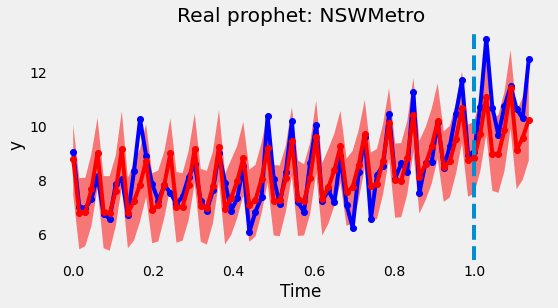

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


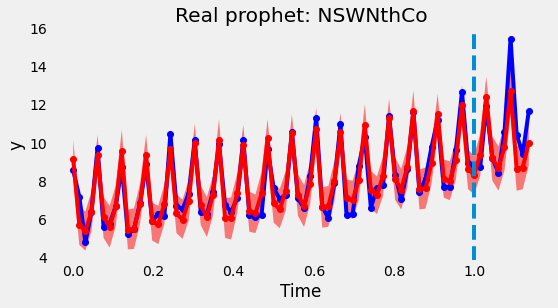

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


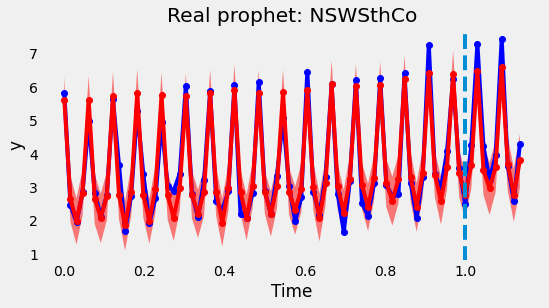

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


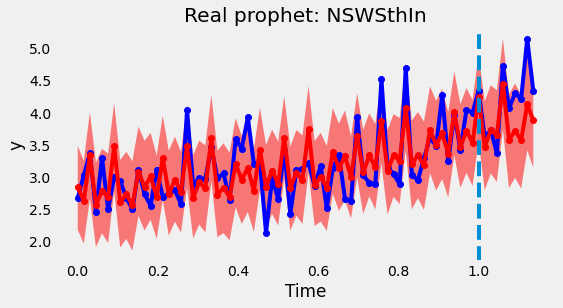

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


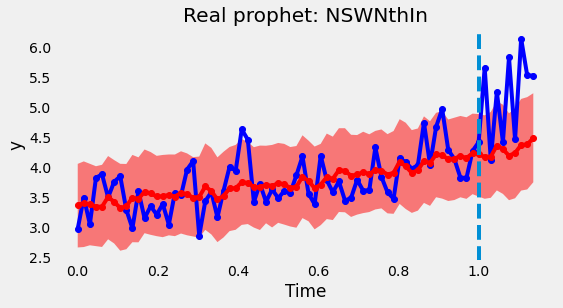

In [15]:
from fbprophet import Prophet

yhat_prophet_zones = []

for zone in zones:
    df = visnights.loc[:,zone]
    df_train = df.iloc[0:(df.shape[0] - horizon)]
    df_train = pd.DataFrame({'ds': df_train.index, 'y': df_train.values})
    
    fit_prophet = Prophet(n_changepoints = n_changepoints, mcmc_samples=1000)
    fit_prophet.fit(df_train)
    
    df_test = pd.DataFrame({'ds': df.index})
    
    pred_prophet = fit_prophet.predictive_samples(df_test)
    yhat_prophet = pred_prophet['yhat']
    yhat_prophet_zones.append(yhat_prophet)
    
    plot_prophet(ts = df.values, 
                 yhat = yhat_prophet, horizon = 10, 
                 title = "Real prophet: "+ zone)

## 6. Hierarchical Approach  <a class="anchor" id="hierarchical_6"></a>

As noted from the plot in [Section 2 (Data)](#data2), all series share common features of trend and seasonality. For instance, tourism demand exhibits yearly seasonality, and this is reflected in spikes in each series during the first quarter of the year. Also, the series reflect an upward trend that is more pronounced in the last few years.

Given the limited data, it is reasonable to think that we should take advantage of the similar structure in the series. Specifically, instead of fitting independent models to each series, we could fit a single model to all series that includes both individual as well as shared parameters. In the context of Bayesian ineference, this is know as *partial pooling*.



### 6.1 The Model  <a class="anchor" id="themodel_61"></a>

We propose the following Hierarchical model in the context of the present forecasting problem.

\begin{align*} 
y &\sim N(\mu_{\text{trend}} + \mu_{\text{seasonality}},\sigma) \\ 
\mu_{\text{trend}} &= (k_{\text{zone}} + \mathbf{A} \mathbf{\delta}_{\text{zone}})t + (m+\mathbf{A} \gamma_{\text{zone}})  \\
\mu_{\text{seasonality}} &= \mathbf{X} \mathbf{\beta}_{\text{zone}} \\
\delta_z &\sim \text{Laplace}(\mu_{\delta},\sigma_{\delta}) \\
k_z &\sim N(\mu_k,\sigma_k) \\
\beta_z &\sim N(\mu_{\beta},\sigma_{\beta}) \\
\gamma_z &= -s * \delta_z \\
m &\sim N(0,5) \\
\sigma &\sim \text{Half-normal}(0,.5)\\
\mu_{\delta} &\sim N(0, 1)\\
\sigma_{\delta} &\sim N(0, 1)\\
\mu_{k} &\sim N(0, 1)\\
\sigma_{k} &\sim N(0,1)\\
\mu_{\beta} &\sim N(0, 1)\\
\sigma_{\beta} &\sim N(0, 1)\\
\end{align*}

where $z = \{1, \ldots, Z\}$ indexes the zones.


### 6.2 Stan Code and Fitting Procedure <a class="anchor" id="stanfit_62"></a>


In [16]:
### Stored in "stan_model_hierarchical.stan"

stan_model_hierarchical = """
data { 
  int N;                              // Number of time periods
  int N_changepoints;                 // Number of changepoints
  vector[N_changepoints] s;           // Changepoints
  matrix[N, N_changepoints] A;        // Changepoint Matrix
  vector[N] t;                        // Time
  int n_fourier;                      // Fourier series expansion
  matrix[N, n_fourier * 2] X;         // Seasonality matrix
  vector[N] y;                        // Time series
  int<lower=0> J;                     // Number of groups
  int<lower=1,upper=J> group[N];      // Group variable (integer from 1 to number of groups)
  
} 
 
parameters { 
    
  vector[J] k;                       // Base trend growth rate by group
  real m;                            // Trend offset
  vector[N_changepoints] delta[J];   // Trend rate adjustments by group
  vector[n_fourier * 2] beta[J];     // Seasonality regressor coefficients by group  
  vector[n_fourier * 2] mu_beta;     // beta global mean 
  real<lower=0> sigma_beta;          // Seasonality  noise global mean 
  vector[N_changepoints] mu_delta;   // delta global mean (changepoints)
  real<lower=0> sigma_delta;         // dela global noise (changepoints)
  real mu_k;                         // k global mean 
  real<lower=0> sigma_k;             // k global noise
  real<lower=0> sigma;               // Observation noise
 
} 

transformed parameters { 
  
  vector[N_changepoints] gamma[J];
  vector[N] mu_trend; 
  vector[N] mu_s;
  
  for(n in 1:N){
      gamma[group[n]] = -s .* delta[group[n]];
      mu_trend[n] = k[group[n]] + A[n] * delta[group[n]] .* t[n] + (m + A[n] * gamma[group[n]]);
      mu_s[n] = X[n] * beta[group[n]]; 
  } 
} 
 
model { 

  // Hyper-priors
  m ~ normal(0, 5);
  sigma ~ normal(0, 0.5);
  mu_beta ~ normal(0, 1);
  sigma_beta ~ normal(0, 1);
  mu_delta ~ normal(0, 1);
  sigma_delta ~ normal(0, 1);
  mu_k ~ normal(0, 1);
  sigma_k ~ normal(0,1);

  // Adaptive priors

  for(j in 1:J){
    k[j] ~ normal(mu_k, sigma_k);
    delta[j] ~ double_exponential(mu_delta, sigma_delta);
    beta[j] ~ normal(mu_beta, sigma_beta);
  }

  // Linear likelihood
  y ~ normal(mu_trend + mu_s, sigma);
} 

generated quantities { 
    
    vector[N] y_hat;
    for (n in 1:N)
        y_hat[n] = normal_rng(mu_trend[n] + mu_s[n], sigma);  
}
"""

In [17]:
# Pre-process data to fit all series simultaneously 
visnights_train = visnights.iloc[0:(visnights.shape[0] - horizon)]
visnights_long = visnights
visnights_long = visnights_long .reset_index()
visnights_long = pd.melt(visnights_long, id_vars='date', 
                          value_vars= zones, 
                          var_name = 'zone', 
                          value_name = 'y')

visnights_train_long = visnights_train
visnights_train_long  = visnights_train_long.reset_index()
visnights_train_long  = pd.melt(visnights_train_long, id_vars='date', 
                          value_vars= zones, 
                          var_name = 'zone', 
                          value_name = 'y')
visnights_train_long.head()

,date,zone,y
0,1998-01-01,NSWMetro,9.047095
1,1998-04-01,NSWMetro,7.005006
2,1998-07-01,NSWMetro,6.956874
3,1998-10-01,NSWMetro,7.280171
4,1999-01-01,NSWMetro,8.154772


In [18]:
# Get model input feeds and fit
ts = visnights_train_long['y'].values
zone_var = visnights_train_long['zone'].values

# Trend inputs
t, s, A = get_linear_trend_data(ts, n_changepoints = n_changepoints, group_var=zone_var)

# Seasonality inputs
X = fourier_series(t, p=p, fourier_order=n_fourier) # p=4 becuase we have yearly seasonality with quarterly data

stan_data_dict = {'N':visnights_train_long.shape[0],
                  'N_changepoints':len(s),
                  's': s,
                  'A': A,
                  't': t,
                  'n_fourier':n_fourier,
                  'X':X,
                  'y': visnights_train_long['y'].values,
                  'J': len(np.unique(zone_var)),
                  'group':np.repeat(list(range(1,6)), visnights_train.shape[0]) # stan start index = 1
                  }

sm = pystan.StanModel('../stan/stan_model_hierarchical.stan') 
multiprocessing.set_start_method("fork", force=True)
fit5 = sm.sampling(data=stan_data_dict, iter=1000, chains=4, seed=197342, control=dict(max_treedepth=15))

summary_stan_fit = stan_model_summary(fit5)
summary_stan_fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a814522702ab4e62a6a38e30becb58c3 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
k[1],2.956810,0.032210,1.331686,0.362354,2.039116,2.903406,3.861695,5.626984,1709.341091,0.998754
k[2],2.253236,0.032781,1.318295,-0.222528,1.372176,2.215946,3.118873,4.948464,1617.238769,0.998709
k[3],-1.076108,0.032273,1.298745,-3.493707,-1.990639,-1.098791,-0.224988,1.548767,1619.456744,0.999544
k[4],-1.467121,0.030605,1.316980,-4.009644,-2.367866,-1.489956,-0.605996,1.173955,1851.753005,1.000155
k[5],-0.938327,0.032051,1.309904,-3.449157,-1.846879,-0.929835,-0.059168,1.663003,1670.325097,0.999686
...,...,...,...,...,...,...,...,...,...,...
y_hat[327],4.338848,0.011967,0.528961,3.294887,3.987972,4.341186,4.692916,5.372033,1953.734572,0.999863
y_hat[328],4.363978,0.012095,0.531786,3.342407,4.012264,4.365272,4.739436,5.378041,1933.038396,1.004164
y_hat[329],4.423402,0.012664,0.527037,3.405775,4.063767,4.419262,4.776525,5.426958,1731.967731,1.000745
y_hat[330],4.504722,0.012514,0.552222,3.434817,4.135325,4.498465,4.882784,5.607284,1947.326859,0.999137


### 6.3 MCMC Diagnostics <a class="anchor" id="diagnostics_63"></a>

Firstly, we want to ensure that the *Rhat* for each parameter is close to 1. Empirically, *Rhat* $> 1$ is usually indicative of problems in the fit. All parameters look good here. 

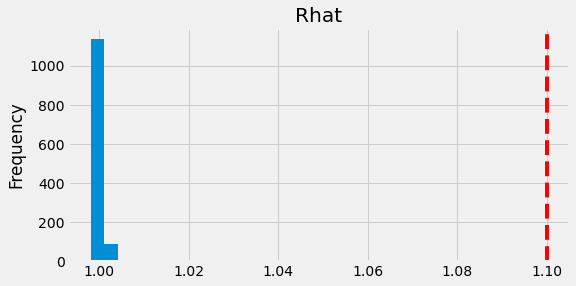

In [19]:
r_hat = summary_stan_fit['Rhat']
r_hat.plot.hist(title="Rhat")
plt.axvline(1.1, color='r', linestyle='--')

Then, we want to consider the effective sample size, or *n_eff*. Low samples per transition are consequences of poorly mixing Markov chains.

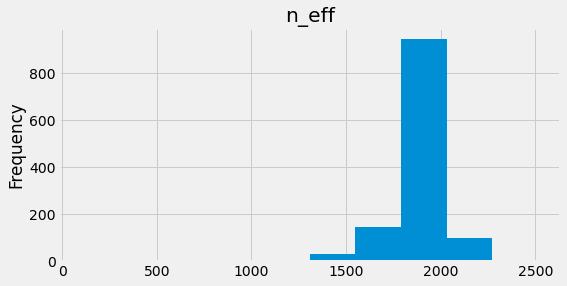

In [20]:
summary_stan_fit['n_eff'].plot.hist(title="n_eff")

The dynamic implementation of Hamiltonian Monte Carlo used in Stan has a maximum trajectory length built in to avoid infinite loops that can occur for non-identified models. For sufficiently complex models, however, Stan can saturate this threshold even if the model is identified, which limits the efficacy of the sampler. However, warnings about hitting the maximum treedepth are not as serious as warnings about divergent transitions. While divergent transitions are a validity concern, hitting the maximum treedepth is an efficiency concern.

In [21]:
stan_utility.utils.check_treedepth(fit5)  

1434 of 2000 iterations saturated the maximum tree depth of 10 (71.7%)
  Run again with max_treedepth set to a larger value to avoid saturation


We next check the Estimated Bayesian Fraction of Missing Information (E-BFMI). E-BFMI below 0.2 indicate that the adaptation phase of the Markov Chains did not turn out well and those chains likely did not explore the posterior distribution efficiently.

In [22]:
stan_utility.utils.check_energy(fit5)

E-BFMI indicated no pathological behavior


Lastly, we can check divergences which indicate pathological neighborhoods of the posterior that the simulated Hamiltonian trajectories are not able to explore sufficiently well. No issues here. 

In [23]:
stan_utility.utils.check_div(fit5)

0.0 of 2000 iterations ended with a divergence (0.0%)


### 6.4 Forecasts <a class="anchor" id="forecasts_64"></a>


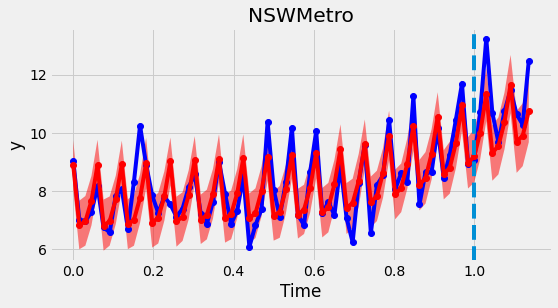

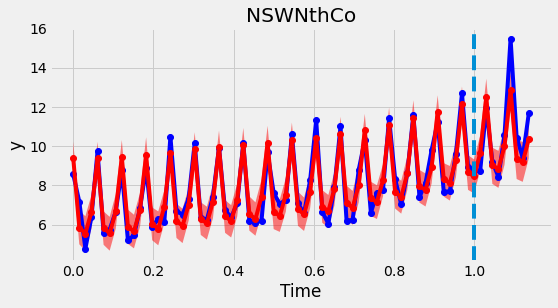

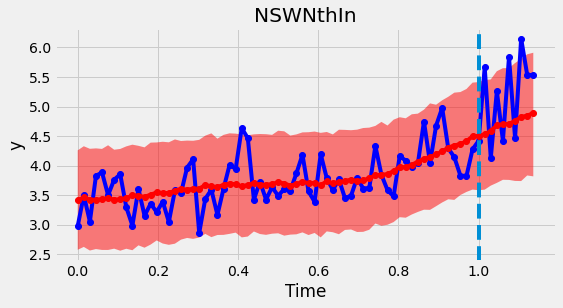

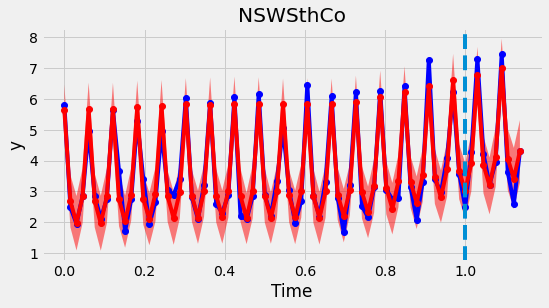

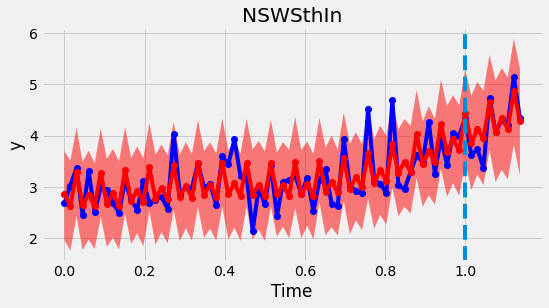

In [24]:
y_hat, mu_trend, mu_s, train_ind = forecast_hierarchical(stan_fit=fit5, p=4, horizon=10)
plot_posterior(fit5, ts = visnights_long['y'].values, 
               yhat = y_hat, horizon = horizon, group= visnights_long['zone'].values)

## 7. Prediction Error <a class="anchor" id="#pred_error7"></a>

Let's now compare the prediction error between the Hierarchical approach and the Prophet package. The hierarchical approach achieves approximately 20% lower error based on RMSE.

In [25]:
# Hierarchical
rmse_h = (np.mean(y_hat[:,train_ind == False], axis=0) - \
          visnights_long['y'].values[train_ind == False])
rmse_h = np.sqrt(sum(rmse_h ** 2)/ len(rmse_h))
print("Hierarchical RMSE:", rmse_h)

#Prophet
rmse_p = (np.mean(np.vstack(yhat_prophet_zones)[train_ind == False, :], axis=1) - \
          visnights_long['y'].values[train_ind == False])
rmse_p = np.sqrt(sum(rmse_p ** 2)/ len(rmse_p))
print("Prophet RMSE:", rmse_p)

Hierarchical RMSE: 0.7776377532499573
Prophet RMSE: 0.9970293013999644
